# Exact Shapley Value Computation for Federated Learning (Ensemble)

This notebook computes **exact Shapley values** to quantify each client's contribution to the global model.

## Ensemble Setup

Each client uses an **ensemble of 3 models**:
1. **UNet + ResNet50**
2. **UNet + MiT-B3**
3. **DeepLabV3+ + MobileNetV3**

The final prediction is a **weighted average of logits** from all three models.

## Shapley Value Formula

For client $i$, the Shapley value is:

$$\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} \left[ v(S \cup \{i\}) - v(S) \right]$$

Where:
- $v(S)$ = utility (Dice/IoU) of the **ensemble** model aggregated from coalition $S$
- The weight accounts for all permutations where $S$ precedes $i$

In [2]:
import os
import json
import itertools
import math
from typing import Dict, List, Tuple, Set, FrozenSet, NamedTuple
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Configuration

Update these paths to match your setup.

In [ ]:
# Path to federated learning client checkpoints
CLIENT_BASE_DIR = "/home/stefanvulpe/master/AITDM/final_models"

# Number of FL clients
NUM_CLIENTS = 3


class ModelConfig(NamedTuple):
    """Configuration for a single model in the ensemble."""

    name: str  # Identifier (e.g., "unet_resnet50")
    architecture: str  # "unet" or "deeplabv3plus"
    encoder_name: str  # timm encoder name
    encoder_weights: str  # pretrained weights (e.g., "imagenet")
    checkpoint_subdir: str  # subdirectory in client folder


# Define the 3 models in each client's ensemble
ENSEMBLE_MODELS = [
    ModelConfig(
        name="unet_resnet50",
        architecture="unet",
        encoder_name="resnet50",
        encoder_weights="imagenet",
        checkpoint_subdir="unet__resnet50",
    ),
    ModelConfig(
        name="unet_mit_b3",
        architecture="unet",
        encoder_name="mit_b3",
        encoder_weights="imagenet",
        checkpoint_subdir="unet__mit_b3",
    ),
    ModelConfig(
        name="deeplabv3plus_mobilenetv3",
        architecture="deeplabv3plus",
        encoder_name="timm-mobilenetv3_small_100",
        encoder_weights="imagenet",
        checkpoint_subdir="deeplabv3plus__timm-mobilenetv3_small_100",
    ),
]


WEIGHT_MODE = "power"  # Options: "power", "linear"
WEIGHT_POWER = (
    14.0  # Exponent for power weighting (higher = more weight to best model)
)
WEIGHT_EPS = 1e-6  # Small epsilon to avoid division by zero

# Model hyperparameters
NUM_CLASSES = 1  # Binary segmentation
IN_CHANNELS = 2  # 2 MRI modalities (FLAIR, T1)

# Data configuration
DATA_DIR = "/home/stefanvulpe/master/AITDM/Preprocessed-Data"
BATCH_SIZE = 8
NUM_WORKERS = 0

print("Configuration loaded:")
print(
    f"  - {NUM_CLIENTS} clients, each with {len(ENSEMBLE_MODELS)} models in ensemble"
)
print(f"  - Dynamic weights: mode={WEIGHT_MODE}, power={WEIGHT_POWER}")
print(f"  - Data directory: {DATA_DIR}")
print(f"  - Checkpoint directory: {CLIENT_BASE_DIR}")

Configuration loaded:
  - 3 clients, each with 3 models in ensemble
  - Dynamic weights: mode=power, power=14.0
  - Data directory: /home/stefanvulpe/master/AITDM/Preprocessed-Data
  - Checkpoint directory: /home/stefanvulpe/master/AITDM/final_models


## 2. Dataset Classes

Load MRI data and tumor masks for evaluation.

In [ ]:
class GliomaDataset(Dataset):
    """Dataset that loads MRI, tumor mask, and optional atlas regions per patient."""

    def __init__(
        self,
        metadata_df_path,
        data_root,
        use_atlas=True,
        exclude_ids=None,
        transform=None,
    ):
        # Load metadata dataframe
        with open(metadata_df_path, "rb") as f:
            df = pickle.load(f)

        # Optionally exclude some patient IDs
        if exclude_ids is None:
            exclude_ids = ["PatientID_0191"]
        self.df = df[~df["Patient_ID"].isin(exclude_ids)].reset_index(drop=True)

        self.data_root = data_root
        self.use_atlas = use_atlas
        self.transform = transform

        # Collect patient IDs that have all required files
        self.patient_ids = []
        for pid in sorted(self.df["Patient_ID"].tolist()):
            mri_p = os.path.join(self.data_root, pid, f"{pid}_mri.npy")
            tumor_p = os.path.join(self.data_root, pid, f"{pid}_tumor.npy")

            if self.use_atlas:
                reg_p = os.path.join(self.data_root, pid, f"{pid}_regions.npy")
                if (
                    os.path.isfile(mri_p)
                    and os.path.isfile(tumor_p)
                    and os.path.isfile(reg_p)
                ):
                    self.patient_ids.append(pid)
            else:
                if os.path.isfile(mri_p) and os.path.isfile(tumor_p):
                    self.patient_ids.append(pid)

    def __len__(self):
        return len(self.patient_ids)

    @staticmethod
    def _minmax(x):
        """Simple min-max normalization to [0, 1]."""
        x = x.astype(np.float32)
        mn, mx = np.min(x), np.max(x)
        return (
            (x - mn) / (mx - mn)
            if mx > mn
            else np.zeros_like(x, dtype=np.float32)
        )

    def __getitem__(self, idx):
        """Load and return one sample (dict) for a patient."""

        pid = self.patient_ids[idx]
        base = os.path.join(self.data_root, pid)

        mri = np.load(os.path.join(base, f"{pid}_mri.npy")).astype(np.float32)
        tumor = np.load(os.path.join(base, f"{pid}_tumor.npy")).astype(
            np.float32
        )

        mri = self._minmax(mri)
        tumor = (tumor > 0.5).astype(np.float32)

        sample = {"patient_id": pid, "mri": mri, "tumor": tumor}

        if self.use_atlas:
            regions = np.load(os.path.join(base, f"{pid}_regions.npy")).astype(
                np.float32
            )
            regions = self._minmax(regions)
            sample["regions"] = regions

        return sample


def image_only_collate_fn(batch, use_atlas=True):
    """Custom collate: stack MRI (+ optional regions) and tumor into tensors."""
    mri = torch.stack([torch.tensor(it["mri"]) for it in batch]).unsqueeze(1)
    y = torch.stack([torch.tensor(it["tumor"]) for it in batch]).unsqueeze(1)

    if use_atlas:
        regs = torch.stack(
            [torch.tensor(it["regions"]) for it in batch]
        ).unsqueeze(1)
        # Concatenate MRI and regions as channels
        x = torch.cat([mri.float(), regs.float()], dim=1)
    else:
        x = mri.float()

    return {"x": x, "y": y.float(), "pid": [it["patient_id"] for it in batch]}


In [ ]:
def create_single_model(config: ModelConfig) -> nn.Module:
    """
    Create a single segmentation model based on configuration.

    Args:
        config: ModelConfig with architecture, encoder, and weights info

    Returns:
        PyTorch model (UNet or DeepLabV3+)
    """
    if config.architecture == "unet":
        model = smp.Unet(
            encoder_name=config.encoder_name,
            encoder_weights=config.encoder_weights,
            in_channels=IN_CHANNELS,
            classes=NUM_CLASSES,
        )
    elif config.architecture == "deeplabv3plus":
        model = smp.DeepLabV3Plus(
            encoder_name=config.encoder_name,
            encoder_weights=config.encoder_weights,
            in_channels=IN_CHANNELS,
            classes=NUM_CLASSES,
        )
    else:
        raise ValueError(f"Unknown architecture: {config.architecture}")

    return model


def create_ensemble_models() -> List[nn.Module]:
    """
    Create all models in the ensemble.

    Returns:
        List of 3 models (fresh weights, ready to load checkpoints)
    """
    models = []
    for config in ENSEMBLE_MODELS:
        model = create_single_model(config)
        models.append(model)
    return models


def load_best_val_dice(config: ModelConfig, client_id: int) -> float:
    """
    Load the best validation Dice score for a specific model and client.

    Reads from: CLIENT_BASE_DIR/{checkpoint_subdir}/checkpoints/client_{cid}_best.json

    Args:
        config: ModelConfig for the model
        client_id: Client ID

    Returns:
        Best validation Dice score (float)
    """
    best_json_path = os.path.join(
        CLIENT_BASE_DIR,
        config.checkpoint_subdir,
        "checkpoints",
        f"client_{client_id}_best.json",
    )

    if not os.path.isfile(best_json_path):
        print(f"  ⚠ Best JSON not found: {best_json_path}, using default 0.5")
        return 0.5

    with open(best_json_path, "r") as f:
        data = json.load(f)

    return float(data.get("val_dice", 0.5))


def compute_ensemble_weights(
    client_id: int,
    mode: str = WEIGHT_MODE,
    power: float = WEIGHT_POWER,
    eps: float = WEIGHT_EPS,
) -> Tuple[List[float], List[float]]:
    """
    Compute dynamic ensemble weights based on best validation Dice scores.

    The weights are computed using either:
    - "linear": w_i = dice_i / sum(dice_j)
    - "power": w_i = dice_i^power / sum(dice_j^power)

    Higher power values give more weight to the best-performing model.

    Args:
        client_id: Client ID to compute weights for
        mode: Weighting mode ("linear" or "power")
        power: Exponent for power weighting
        eps: Small epsilon to avoid division by zero

    Returns:
        (weights, best_dices) tuple:
        - weights: List of ensemble weights (sum to 1)
        - best_dices: List of best Dice scores per model
    """
    # Load best Dice scores for each model in the ensemble
    best_dices = [
        load_best_val_dice(config, client_id) for config in ENSEMBLE_MODELS
    ]
    dices = np.array(best_dices, dtype=np.float32)

    # Compute raw weights based on mode
    if mode == "linear":
        raw = np.clip(dices, 0.0, None)
    elif mode == "power":
        raw = np.power(np.clip(dices, 0.0, None), power)
    else:
        raise ValueError(f"mode must be 'linear' or 'power', got: {mode}")

    # Add epsilon and normalize to sum to 1
    raw = raw + eps
    weights = raw / raw.sum()

    return weights.tolist(), best_dices


def ensemble_forward(
    x: torch.Tensor,
    models: List[nn.Module],
    weights: List[float],
    target_hw: Tuple[int, int] = None,
) -> torch.Tensor:
    """
    Forward pass through ensemble with weighted logit averaging.

    The ensemble combines predictions by:
    1. Getting logits from each model
    2. Resizing all logits to target resolution (if needed)
    3. Computing weighted sum of logits
    4. Applying sigmoid for final probability

    Args:
        x: Input tensor [B, C, H, W]
        models: List of ensemble models
        weights: Ensemble weights for each model (dynamically computed)
        target_hw: Target (H, W) for output, defaults to input size

    Returns:
        Probability map [B, 1, H, W] (after sigmoid)
    """
    if target_hw is None:
        target_hw = (x.shape[2], x.shape[3])

    w = np.array(weights, dtype=np.float32)
    w = w / (w.sum() + 1e-8)

    combined_logits = None

    with torch.no_grad():
        for model, wi in zip(models, w):
            logits = model(x)  # [B, 1, H', W']

            # Resize to target resolution if needed
            if logits.shape[2:] != target_hw:
                logits = F.interpolate(
                    logits, size=target_hw, mode="bilinear", align_corners=False
                )

            # Weighted accumulation
            if combined_logits is None:
                combined_logits = float(wi) * logits
            else:
                combined_logits += float(wi) * logits

    # Apply sigmoid to get probabilities
    probs = torch.sigmoid(combined_logits)
    return probs


print("✓ Model creation functions defined:")
print("  - create_single_model(config)")
print("  - create_ensemble_models()")
print("  - load_best_val_dice(config, client_id)")
print("  - compute_ensemble_weights(client_id, mode, power, eps)")
print("  - ensemble_forward(x, models, weights)")

✓ Model creation functions defined:
  - create_single_model(config)
  - create_ensemble_models()
  - load_best_val_dice(config, client_id)
  - compute_ensemble_weights(client_id, mode, power, eps)
  - ensemble_forward(x, models, weights)


## 3. Model and Utility Functions

In [ ]:
def calc_metrics_from_probs(
    y_true: torch.Tensor, y_pred_prob: torch.Tensor, threshold: float = 0.5
) -> Tuple[float, float, float]:
    """
    Compute Dice, IoU, and Accuracy using smp.metrics.

    Args:
        y_true: Ground truth tensor (B, 1, H, W)
        y_pred_prob: Predicted probability tensor (B, 1, H, W) - already sigmoid applied
        threshold: Threshold for binarization

    Returns:
        (dice, iou, accuracy) tuple
    """
    tp, fp, fn, tn = smp.metrics.functional.get_stats(
        y_pred_prob, y_true.long(), mode="binary", threshold=threshold
    )

    dice = smp.metrics.functional.f1_score(tp, fp, fn, tn, reduction="micro")

    iou = smp.metrics.functional.iou_score(tp, fp, fn, tn, reduction="micro")

    acc = smp.metrics.functional.accuracy(tp, fp, fn, tn, reduction="micro")

    return float(dice), float(iou), float(acc)


@torch.no_grad()
def evaluate_ensemble(
    models: List[nn.Module],
    dataloader: DataLoader,
    weights: List[float],
    threshold: float = 0.5,
) -> Dict[str, float]:
    """
    Evaluate ensemble of models on dataloader, return metrics.

    Args:
        models: List of ensemble models (already loaded with weights)
        dataloader: DataLoader for evaluation data
        weights: Ensemble weights for combining predictions (dynamically computed)
        threshold: Threshold for binarization

    Returns:
        Dict with 'dice', 'iou', 'acc' metrics
    """
    for model in models:
        model.eval()
        model.to(DEVICE)

    total_dice = total_iou = total_acc = 0.0
    n_batches = 0

    for batch in dataloader:
        x = batch["x"].to(DEVICE)
        y = batch["y"].to(DEVICE)

        probs = ensemble_forward(
            x, models, weights, target_hw=(y.shape[2], y.shape[3])
        )

        dice, iou, acc = calc_metrics_from_probs(y, probs, threshold)
        total_dice += dice
        total_iou += iou
        total_acc += acc
        n_batches += 1

    n_batches = max(n_batches, 1)
    return {
        "dice": total_dice / n_batches,
        "iou": total_iou / n_batches,
        "acc": total_acc / n_batches,
    }


print("✓ Evaluation functions defined:")
print("  - calc_metrics_from_probs(y_true, y_pred_prob)")
print("  - evaluate_ensemble(models, dataloader, weights)")

✓ Evaluation functions defined:
  - calc_metrics_from_probs(y_true, y_pred_prob)
  - evaluate_ensemble(models, dataloader, weights)


## 4. FedAvg Aggregation

In [ ]:
def fedavg_aggregate_ensemble(
    client_ensemble_weights: Dict[int, List[Dict[str, torch.Tensor]]],
    num_samples: Dict[int, int],
    coalition: Set[int],
) -> List[Dict[str, torch.Tensor]]:
    """
    Aggregate ensemble model weights from a coalition of clients using FedAvg.

    Each client has an ensemble of N models. We aggregate each model separately
    using FedAvg (weighted by number of training samples).

    Args:
        client_ensemble_weights: Dict mapping client_id -> List[state_dict]
                                 (one state_dict per ensemble model)
        num_samples: Dict mapping client_id -> number of training samples
        coalition: Set of client IDs to include

    Returns:
        List of aggregated state_dicts (one per ensemble model)
    """
    num_models = len(ENSEMBLE_MODELS)

    if len(coalition) == 0:
        first_client_weights = list(client_ensemble_weights.values())[0]
        return [
            {k: torch.zeros_like(v) for k, v in model_weights.items()}
            for model_weights in first_client_weights
        ]

    # Compute weights proportional to number of samples
    total_samples = sum(num_samples[c] for c in coalition)
    sample_weights = {c: num_samples[c] / total_samples for c in coalition}

    # Aggregate each model in the ensemble separately
    aggregated_ensemble = []

    for model_idx in range(num_models):
        # Get state dict keys from first client in coalition
        first_client = list(coalition)[0]
        state_dict_keys = client_ensemble_weights[first_client][
            model_idx
        ].keys()

        # Weighted average of parameters for this model
        aggregated = {}
        for key in state_dict_keys:
            aggregated[key] = sum(
                sample_weights[c]
                * client_ensemble_weights[c][model_idx][key].float()
                for c in coalition
            )

        aggregated_ensemble.append(aggregated)

    return aggregated_ensemble


print("✓ FedAvg ensemble aggregation defined")

✓ FedAvg ensemble aggregation defined


## 5. Exact Shapley Value Computation

The core algorithm that evaluates all 2^N = 8 coalitions.

In [ ]:
class ExactShapleyCalculator:
    """
    Computes exact Shapley values by evaluating all 2^N coalitions.

    Adapted for ENSEMBLE models: each client has 3 models that are
    aggregated separately via FedAvg, then combined using weighted
    logit averaging for prediction.

    DYNAMIC WEIGHTS: Ensemble weights are computed per-coalition based on
    the aggregated models' best validation Dice scores. For a coalition S,
    we compute weights from the FedAvg-aggregated model performance.

    For N=3 clients, we evaluate 8 coalitions:
    ∅, {0}, {1}, {2}, {0,1}, {0,2}, {1,2}, {0,1,2}
    """

    def __init__(
        self,
        client_ensemble_weights: Dict[int, List[Dict[str, torch.Tensor]]],
        client_best_dices: Dict[int, List[float]],
        num_samples: Dict[int, int],
        val_loader: DataLoader,
        utility_metric: str = "dice",
    ):
        """
        Args:
            client_ensemble_weights: Dict[client_id -> List[state_dict]]
                Each client has a list of state_dicts, one per ensemble model.
            client_best_dices: Dict[client_id -> List[float]]
                Best validation Dice scores per model for each client.
            num_samples: Dict[client_id -> num_training_samples]
            val_loader: DataLoader for validation data
            utility_metric: "dice", "iou", or "acc"
        """
        self.client_ensemble_weights = client_ensemble_weights
        self.client_best_dices = client_best_dices
        self.num_samples = num_samples
        self.val_loader = val_loader
        self.utility_metric = utility_metric
        self.clients = sorted(client_ensemble_weights.keys())
        self.n = len(self.clients)

        # Cache for coalition utilities and weights
        self.coalition_utilities: Dict[FrozenSet[int], float] = {}
        self.coalition_weights: Dict[FrozenSet[int], List[float]] = {}

    def _compute_coalition_weights(
        self, coalition: Set[int]
    ) -> Tuple[List[float], List[float]]:
        """
        Compute dynamic ensemble weights for a coalition.

        For a coalition, we aggregate the best Dice scores from participating
        clients (weighted by num_samples) and then compute ensemble weights.

        Args:
            coalition: Set of client IDs

        Returns:
            (weights, aggregated_dices) tuple
        """
        if len(coalition) == 0:
            num_models = len(ENSEMBLE_MODELS)
            return [1.0 / num_models] * num_models, [0.0] * num_models

        # Aggregate best Dice scores using sample-weighted average
        total_samples = sum(self.num_samples[c] for c in coalition)
        sample_weights = {
            c: self.num_samples[c] / total_samples for c in coalition
        }

        num_models = len(ENSEMBLE_MODELS)
        aggregated_dices = []

        for model_idx in range(num_models):
            # Weighted average of Dice scores for this model
            agg_dice = sum(
                sample_weights[c] * self.client_best_dices[c][model_idx]
                for c in coalition
            )
            aggregated_dices.append(agg_dice)

        # Compute weights using power weighting
        dices = np.array(aggregated_dices, dtype=np.float32)

        if WEIGHT_MODE == "linear":
            raw = np.clip(dices, 0.0, None)
        elif WEIGHT_MODE == "power":
            raw = np.power(np.clip(dices, 0.0, None), WEIGHT_POWER)
        else:
            raw = np.clip(dices, 0.0, None)

        raw = raw + WEIGHT_EPS
        weights = raw / raw.sum()

        return weights.tolist(), aggregated_dices

    def _get_utility(self, coalition: Set[int]) -> float:
        """Get utility for a coalition, using cache."""
        key = frozenset(coalition)

        if key in self.coalition_utilities:
            return self.coalition_utilities[key]

        if len(coalition) == 0:
            # Convention: empty coalition has utility 0
            utility = 0.0
            weights = [1.0 / len(ENSEMBLE_MODELS)] * len(ENSEMBLE_MODELS)
        else:
            # Aggregate ensemble weights via FedAvg
            agg_ensemble_weights = fedavg_aggregate_ensemble(
                self.client_ensemble_weights, self.num_samples, coalition
            )

            # Compute dynamic weights for this coalition
            weights, agg_dices = self._compute_coalition_weights(coalition)

            # Create ensemble models and load aggregated weights
            models = create_ensemble_models()
            for model, model_weights in zip(models, agg_ensemble_weights):
                model.load_state_dict(model_weights)
                model.to(DEVICE)
                model.eval()

            # Evaluate ensemble with dynamic weights
            metrics = evaluate_ensemble(models, self.val_loader, weights)
            utility = metrics[self.utility_metric]

            # Cleanup
            del models
            torch.cuda.empty_cache()

        # Cache results
        self.coalition_utilities[key] = utility
        self.coalition_weights[key] = weights
        return utility

    def compute_all_coalitions(self) -> Dict[FrozenSet[int], float]:
        """
        Evaluate utility for ALL 2^N coalitions.
        """
        print(f"\nEvaluating all {2**self.n} coalitions...")
        print(f"Dynamic weights: mode={WEIGHT_MODE}, power={WEIGHT_POWER}")
        print("=" * 60)

        # Generate all subsets (power set)
        for r in range(self.n + 1):
            for coalition in itertools.combinations(self.clients, r):
                coalition_set = set(coalition)
                utility = self._get_utility(coalition_set)
                weights = self.coalition_weights.get(
                    frozenset(coalition_set), []
                )

                coalition_str = (
                    "{" + ", ".join(map(str, sorted(coalition_set))) + "}"
                    if coalition_set
                    else "∅"
                )
                weights_str = "[" + ", ".join(f"{w:.3f}" for w in weights) + "]"
                print(
                    f"  Coalition {coalition_str:15s} → {self.utility_metric}: {utility:.6f} | weights: {weights_str}"
                )

        return self.coalition_utilities

    def compute_shapley_values(self) -> Dict[int, float]:
        """
        Compute exact Shapley values using the formula:

        φ_i = Σ_{S ⊆ N\\{i}} [|S|!(n-|S|-1)!/n!] × [v(S∪{i}) - v(S)]
        """
        self.compute_all_coalitions()

        print("\n" + "=" * 60)
        print("Computing Shapley values...")
        print("=" * 60)

        shapley_values = {}
        n = self.n

        for i in self.clients:
            phi_i = 0.0

            others = [c for c in self.clients if c != i]

            for r in range(len(others) + 1):
                for S_tuple in itertools.combinations(others, r):
                    S = set(S_tuple)
                    s = len(S)

                    weight = (
                        math.factorial(s) * math.factorial(n - s - 1)
                    ) / math.factorial(n)

                    v_with_i = self.coalition_utilities[frozenset(S | {i})]
                    v_without_i = self.coalition_utilities[frozenset(S)]
                    marginal = v_with_i - v_without_i

                    phi_i += weight * marginal

                    S_str = (
                        "{" + ", ".join(map(str, sorted(S))) + "}" if S else "∅"
                    )
                    print(
                        f"  Client {i} | S={S_str:10s} | weight={weight:.4f} | "
                        f"v(S∪{{{i}}})={v_with_i:.4f} | v(S)={v_without_i:.4f} | "
                        f"marginal={marginal:.4f}"
                    )

            shapley_values[i] = phi_i
            print(f"  → φ_{i} = {phi_i:.6f}\n")

        return shapley_values

    def verify_efficiency(self, shapley_values: Dict[int, float]) -> bool:
        """
        Verify the Efficiency axiom: Σ φ_i = v(N) - v(∅)
        """
        total_shapley = sum(shapley_values.values())
        v_grand = self.coalition_utilities[frozenset(self.clients)]
        v_empty = self.coalition_utilities[frozenset()]
        expected = v_grand - v_empty

        print("\nEfficiency Check:")
        print(f"  Σ φ_i = {total_shapley:.6f}")
        print(f"  v(N) - v(∅) = {v_grand:.6f} - {v_empty:.6f} = {expected:.6f}")
        print(f"  Difference: {abs(total_shapley - expected):.10f}")

        is_valid = abs(total_shapley - expected) < 1e-6
        print(
            "  ✅ Efficiency satisfied!"
            if is_valid
            else "  ❌ Efficiency violated!"
        )

        return is_valid

    def get_coalition_weights_summary(self) -> Dict[str, List[float]]:
        """Return a summary of weights used for each coalition."""
        summary = {}
        for coalition, weights in self.coalition_weights.items():
            coalition_str = (
                "{" + ", ".join(map(str, sorted(coalition))) + "}"
                if coalition
                else "∅"
            )
            summary[coalition_str] = weights
        return summary


print(
    "✓ ExactShapleyCalculator defined (ensemble version with dynamic weights)"
)

✓ ExactShapleyCalculator defined (ensemble version with dynamic weights)


## 6. Load Data and Client Weights

In [ ]:
# Directory containing client data splits (train_pids.json, val_pids.json)
CLIENT_SPLITS_DIR = "/home/stefanvulpe/master/AITDM/client"


def load_client_ensemble_data():
    """
    Load ensemble weights and best Dice scores for all clients.

    Checkpoint structure: CLIENT_BASE_DIR/{model_subdir}/checkpoints/client_{cid}_best.pt
    Best Dice JSON: CLIENT_BASE_DIR/{model_subdir}/checkpoints/client_{cid}_best.json
    Patient splits: CLIENT_SPLITS_DIR/client_{cid}/train_pids.json, val_pids.json

    Returns:
        client_ensemble_weights: Dict[client_id -> List[state_dict]]
            Each client has a list of state_dicts, one per ensemble model.
        client_best_dices: Dict[client_id -> List[float]]
            Best validation Dice scores per model for each client.
        num_samples: Dict[client_id -> num_training_samples]
        all_val_pids: List of all validation patient IDs
    """
    client_ensemble_weights = {}
    client_best_dices = {}
    num_samples = {}
    all_val_pids = []

    for cid in range(NUM_CLIENTS):
        # Patient splits are in client/client_X/
        splits_client_dir = os.path.join(CLIENT_SPLITS_DIR, f"client_{cid}")

        # Load ensemble checkpoints and best Dice scores (one per model type)
        ensemble_weights = []
        best_dices = []
        all_loaded = True

        for config in ENSEMBLE_MODELS:
            # Load model checkpoint
            ckpt_path = os.path.join(
                CLIENT_BASE_DIR,
                config.checkpoint_subdir,
                "checkpoints",
                f"client_{cid}_best.pt",
            )

            if not os.path.exists(ckpt_path):
                print(f"  ⚠ Checkpoint not found: {ckpt_path}")
                all_loaded = False
                break

            state_dict = torch.load(
                ckpt_path, map_location="cpu", weights_only=True
            )
            ensemble_weights.append(state_dict)

            # Load best Dice score from JSON
            best_json_path = os.path.join(
                CLIENT_BASE_DIR,
                config.checkpoint_subdir,
                "checkpoints",
                f"client_{cid}_best.json",
            )

            if os.path.exists(best_json_path):
                with open(best_json_path, "r") as f:
                    best_data = json.load(f)
                best_dice = float(best_data.get("val_dice", 0.5))
            else:
                print(
                    f"  ⚠ Best JSON not found: {best_json_path}, using default 0.5"
                )
                best_dice = 0.5

            best_dices.append(best_dice)

        if not all_loaded:
            print(f"⚠ Skipping client {cid} due to missing checkpoints")
            continue

        client_ensemble_weights[cid] = ensemble_weights
        client_best_dices[cid] = best_dices

        print(
            f"✓ Client {cid}: Loaded {len(ensemble_weights)} model checkpoints"
        )
        print(f"  Best Dice scores: {[f'{d:.4f}' for d in best_dices]}")

        # Compute and display the dynamic weights for this client
        weights, _ = compute_ensemble_weights(cid)
        print(f"  Dynamic weights:  {[f'{w:.4f}' for w in weights]}")

        # Load training sample count from train_pids.json
        train_pids_path = os.path.join(splits_client_dir, "train_pids.json")
        if os.path.exists(train_pids_path):
            with open(train_pids_path, "r") as f:
                train_pids = json.load(f)
            num_samples[cid] = len(train_pids)
            print(f"  Training samples: {num_samples[cid]}")
        else:
            num_samples[cid] = 100  # Default fallback
            print(
                f"  ⚠ train_pids.json not found, using default: {num_samples[cid]}"
            )

        # Load validation patient IDs from val_pids.json
        val_pids_path = os.path.join(splits_client_dir, "val_pids.json")
        if os.path.exists(val_pids_path):
            with open(val_pids_path, "r") as f:
                val_pids = json.load(f)
            all_val_pids.extend(val_pids)
            print(f"  Validation patients: {len(val_pids)}")
        else:
            print(f"  ⚠ val_pids.json not found at {val_pids_path}")

        print()  # Blank line between clients

    # Remove duplicate validation patients
    all_val_pids = list(set(all_val_pids))

    print(f"✓ Loaded {len(client_ensemble_weights)} clients")
    print(f"✓ Total unique validation patients: {len(all_val_pids)}")

    return client_ensemble_weights, client_best_dices, num_samples, all_val_pids


# Run the loading
client_ensemble_weights, client_best_dices, num_samples, all_val_pids = (
    load_client_ensemble_data()
)

✓ Client 0: Loaded 3 model checkpoints
  Best Dice scores: ['0.6505', '0.7662', '0.7185']
  Dynamic weights:  ['0.0671', '0.6630', '0.2699']
  Training samples: 35
  Validation patients: 9

✓ Client 1: Loaded 3 model checkpoints
  Best Dice scores: ['0.7222', '0.7765', '0.6898']
  Dynamic weights:  ['0.2334', '0.6438', '0.1227']
  Training samples: 96
  Validation patients: 25

✓ Client 2: Loaded 3 model checkpoints
  Best Dice scores: ['0.5199', '0.5882', '0.5359']
  Dynamic weights:  ['0.1235', '0.6884', '0.1881']
  Training samples: 29
  Validation patients: 8

✓ Loaded 3 clients
✓ Total unique validation patients: 42


In [ ]:
# Use all validation patients from all clients
if len(all_val_pids) == 0:
    # Fallback: use a subset of patients from DATA_DIR
    all_patients = [
        d for d in os.listdir(DATA_DIR) if d.startswith("PatientID_")
    ]
    all_val_pids = all_patients[:10]  # Use first 10 as validation
    print(
        f"⚠ No validation PIDs found, using {len(all_val_pids)} patients from data dir"
    )

print(f"Creating validation DataLoader with {len(all_val_pids)} patients...")

val_dataset = GliomaDataset(
    metadata_df_path="./cleaned_df.pkl",
    data_root=DATA_DIR,
    use_atlas=True,
    exclude_ids=["PatientID_0191"],
    transform=None,
)

print(f"  Valid patients found: {len(val_dataset)}")

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    collate_fn=image_only_collate_fn,
)

print(f"  Batches: {len(val_loader)}")

Creating validation DataLoader with 42 patients...
  Valid patients found: 202
  Batches: 26


## 7. Compute Exact Shapley Values

In [ ]:
UTILITY_METRIC = "dice"  # Options: "dice", "iou", "acc"

if len(client_ensemble_weights) >= 2:
    print(
        f"Computing Shapley values using '{UTILITY_METRIC}' as utility function..."
    )
    print(
        f"Each coalition will evaluate an ensemble of {len(ENSEMBLE_MODELS)} models"
    )
    print(f"Dynamic weights: mode={WEIGHT_MODE}, power={WEIGHT_POWER}")

    calculator = ExactShapleyCalculator(
        client_ensemble_weights=client_ensemble_weights,
        client_best_dices=client_best_dices,
        num_samples=num_samples,
        val_loader=val_loader,
        utility_metric=UTILITY_METRIC,
    )

    shapley_values = calculator.compute_shapley_values()

    # Verify efficiency axiom
    calculator.verify_efficiency(shapley_values)

    # Print coalition weights summary
    print("\n" + "=" * 60)
    print("Coalition Weights Summary (Dynamic):")
    print("=" * 60)
    for (
        coalition_str,
        weights,
    ) in calculator.get_coalition_weights_summary().items():
        print(
            f"  {coalition_str:15s} → [{', '.join(f'{w:.4f}' for w in weights)}]"
        )
else:
    print("❌ Need at least 2 clients to compute Shapley values.")
    print(f"   Found {len(client_ensemble_weights)} clients")

Computing Shapley values using 'dice' as utility function...
Each coalition will evaluate an ensemble of 3 models
Dynamic weights: mode=power, power=14.0

Evaluating all 8 coalitions...
Dynamic weights: mode=power, power=14.0
  Coalition ∅               → dice: 0.000000 | weights: [0.333, 0.333, 0.333]


Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Coalition {0}             → dice: 0.808231 | weights: [0.067, 0.663, 0.270]


Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Coalition {1}             → dice: 0.825567 | weights: [0.233, 0.644, 0.123]


Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Coalition {2}             → dice: 0.743140 | weights: [0.123, 0.688, 0.188]


Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Coalition {0, 1}          → dice: 0.846529 | weights: [0.175, 0.669, 0.156]


Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Coalition {0, 2}          → dice: 0.831720 | weights: [0.086, 0.678, 0.236]


Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Coalition {1, 2}          → dice: 0.837626 | weights: [0.209, 0.657, 0.134]


Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Coalition {0, 1, 2}       → dice: 0.848222 | weights: [0.167, 0.673, 0.161]

Computing Shapley values...
  Client 0 | S=∅          | weight=0.3333 | v(S∪{0})=0.8082 | v(S)=0.0000 | marginal=0.8082
  Client 0 | S={1}        | weight=0.1667 | v(S∪{0})=0.8465 | v(S)=0.8256 | marginal=0.0210
  Client 0 | S={2}        | weight=0.1667 | v(S∪{0})=0.8317 | v(S)=0.7431 | marginal=0.0886
  Client 0 | S={1, 2}     | weight=0.3333 | v(S∪{0})=0.8482 | v(S)=0.8376 | marginal=0.0106
  → φ_0 = 0.291199

  Client 1 | S=∅          | weight=0.3333 | v(S∪{1})=0.8256 | v(S)=0.0000 | marginal=0.8256
  Client 1 | S={0}        | weight=0.1667 | v(S∪{1})=0.8465 | v(S)=0.8082 | marginal=0.0383
  Client 1 | S={2}        | weight=0.1667 | v(S∪{1})=0.8376 | v(S)=0.7431 | marginal=0.0945
  Client 1 | S={0, 2}     | weight=0.3333 | v(S∪{1})=0.8482 | v(S)=0.8317 | marginal=0.0165
  → φ_1 = 0.302820

  Client 2 | S=∅          | weight=0.3333 | v(S∪{2})=0.7431 | v(S)=0.0000 | marginal=0.7431
  Client 2 | S={0}       

## 8. Visualization

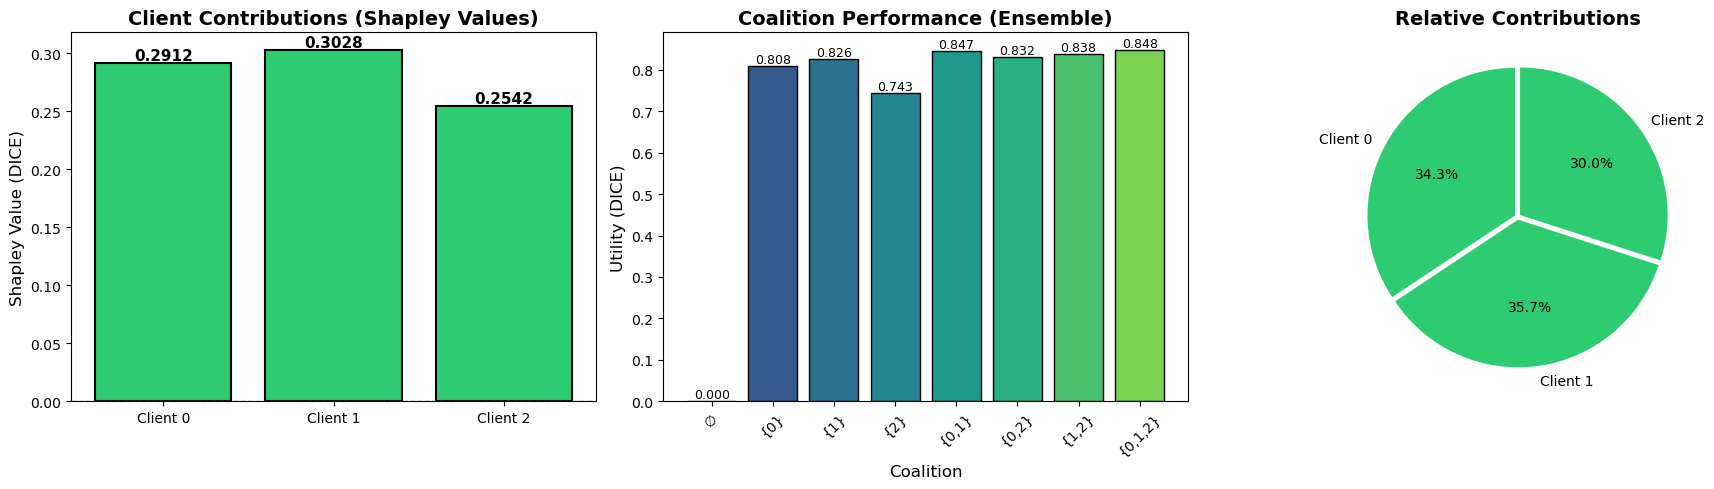


📊 Results saved to /home/stefanvulpe/master/AITDM/shapley_results/shapley_results.png


In [13]:
# Output directory for results
OUTPUT_DIR = "/home/stefanvulpe/master/AITDM/shapley_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def plot_shapley_results(
    shapley_values, coalition_utilities, metric_name="Dice"
):
    """
    Create comprehensive visualizations of Shapley value results.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Shapley Values Bar Chart
    ax1 = axes[0]
    clients = sorted(shapley_values.keys())
    values = [shapley_values[c] for c in clients]
    colors = ["#2ecc71" if v >= 0 else "#e74c3c" for v in values]

    bars = ax1.bar(
        [f"Client {c}" for c in clients],
        values,
        color=colors,
        edgecolor="black",
        linewidth=1.5,
    )
    ax1.axhline(y=0, color="gray", linestyle="--", linewidth=1)
    ax1.set_ylabel(f"Shapley Value ({metric_name})", fontsize=12)
    ax1.set_title(
        "Client Contributions (Shapley Values)", fontsize=14, fontweight="bold"
    )

    for bar, val in zip(bars, values):
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height(),
            f"{val:.4f}",
            ha="center",
            va="bottom" if val >= 0 else "top",
            fontsize=11,
            fontweight="bold",
        )

    # 2. Coalition Utilities
    ax2 = axes[1]

    # Sort coalitions by size then content
    sorted_coalitions = sorted(
        coalition_utilities.keys(), key=lambda x: (len(x), tuple(sorted(x)))
    )

    coalition_labels = []
    utilities = []
    for c in sorted_coalitions:
        label = "{" + ",".join(map(str, sorted(c))) + "}" if c else "∅"
        coalition_labels.append(label)
        utilities.append(coalition_utilities[c])

    colors2 = plt.cm.viridis(np.linspace(0.2, 0.8, len(utilities)))
    bars2 = ax2.bar(
        coalition_labels, utilities, color=colors2, edgecolor="black"
    )
    ax2.set_ylabel(f"Utility ({metric_name})", fontsize=12)
    ax2.set_xlabel("Coalition", fontsize=12)
    ax2.set_title(
        "Coalition Performance (Ensemble)", fontsize=14, fontweight="bold"
    )
    ax2.tick_params(axis="x", rotation=45)

    for bar, val in zip(bars2, utilities):
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height(),
            f"{val:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    # 3. Contribution Pie Chart
    ax3 = axes[2]

    # Normalize Shapley values for pie chart (handle negative values)
    total = sum(abs(v) for v in values)
    if total > 0:
        pie_values = [abs(v) for v in values]
        pie_colors = ["#2ecc71" if v >= 0 else "#e74c3c" for v in values]

        wedges, texts, autotexts = ax3.pie(
            pie_values,
            labels=[f"Client {c}" for c in clients],
            colors=pie_colors,
            autopct="%1.1f%%",
            startangle=90,
            explode=[0.02] * len(clients),
        )
        ax3.set_title("Relative Contributions", fontsize=14, fontweight="bold")

        # Add note about negative values
        if any(v < 0 for v in values):
            ax3.text(
                0,
                -1.3,
                "* Red = negative contribution",
                ha="center",
                fontsize=10,
                style="italic",
            )

    plt.tight_layout()
    plt.savefig(
        os.path.join(OUTPUT_DIR, "shapley_results.png"),
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()

    return fig


if "shapley_values" in dir() and shapley_values:
    fig = plot_shapley_results(
        shapley_values,
        calculator.coalition_utilities,
        metric_name=UTILITY_METRIC.upper(),
    )
    print(f"\n📊 Results saved to {OUTPUT_DIR}/shapley_results.png")

## 9. Results Summary

In [14]:
def print_summary(
    shapley_values, coalition_utilities, num_samples, metric_name="Dice"
):
    """Print formatted summary of results."""
    print("\n" + "=" * 70)
    print("                    SHAPLEY VALUE ANALYSIS SUMMARY")
    print("=" * 70)

    clients = sorted(shapley_values.keys())

    # Ranking
    ranked = sorted(shapley_values.items(), key=lambda x: x[1], reverse=True)

    print(f"\n📊 Client Rankings (by {metric_name} contribution):")
    print("-" * 50)
    for rank, (cid, value) in enumerate(ranked, 1):
        contribution_type = "positive" if value >= 0 else "NEGATIVE"
        samples = num_samples.get(cid, "?")
        print(f"  #{rank}: Client {cid}")
        print(f"       Shapley Value: {value:+.6f} ({contribution_type})")
        print(f"       Training Samples: {samples}")
        print(
            f"       Value per Sample: {value / samples:.8f}"
            if isinstance(samples, int)
            else ""
        )
        print()

    # Coalition analysis
    print("📈 Coalition Performance:")
    print("-" * 50)

    full_coalition = frozenset(clients)
    empty_coalition = frozenset()

    v_full = coalition_utilities[full_coalition]
    v_empty = coalition_utilities[empty_coalition]

    print(f"  Empty coalition (∅):     {v_empty:.6f} {metric_name}")
    print(f"  Full coalition (all):    {v_full:.6f} {metric_name}")
    print(f"  Total improvement:       {v_full - v_empty:.6f} {metric_name}")

    # Best individual
    individual_utils = {
        frozenset([c]): coalition_utilities[frozenset([c])] for c in clients
    }
    best_individual = max(individual_utils.items(), key=lambda x: x[1])
    print(
        f"\n  Best individual client:  {list(best_individual[0])[0]} ({best_individual[1]:.6f})"
    )

    # Synergy analysis
    print("\n🔬 Synergy Analysis:")
    print("-" * 50)
    sum_individuals = sum(coalition_utilities[frozenset([c])] for c in clients)
    synergy = v_full - sum_individuals
    print(f"  Sum of individual utilities: {sum_individuals:.6f}")
    print(f"  Full coalition utility:      {v_full:.6f}")
    print(f"  Synergy (superadditive):     {synergy:+.6f}")
    if synergy > 0:
        print("  → Clients are complementary (positive synergy)")
    elif synergy < 0:
        print("  → Clients have redundant information (negative synergy)")
    else:
        print("  → Clients are independent (no synergy)")

    # Verify axioms
    print("\n✅ Shapley Axiom Verification:")
    print("-" * 50)
    total_shapley = sum(shapley_values.values())
    efficiency_diff = abs(total_shapley - (v_full - v_empty))
    print(
        f"  Efficiency: Σφ_i = {total_shapley:.6f} ≈ v(N)-v(∅) = {v_full - v_empty:.6f}"
    )
    print(
        f"              Difference: {efficiency_diff:.10f} {'✓' if efficiency_diff < 1e-6 else '✗'}"
    )

    print("\n" + "=" * 70)


if "shapley_values" in dir() and shapley_values:
    print_summary(
        shapley_values,
        calculator.coalition_utilities,
        num_samples,
        metric_name=UTILITY_METRIC.upper(),
    )


                    SHAPLEY VALUE ANALYSIS SUMMARY

📊 Client Rankings (by DICE contribution):
--------------------------------------------------
  #1: Client 1
       Shapley Value: +0.302820 (positive)
       Training Samples: 96
       Value per Sample: 0.00315438

  #2: Client 0
       Shapley Value: +0.291199 (positive)
       Training Samples: 35
       Value per Sample: 0.00831998

  #3: Client 2
       Shapley Value: +0.254203 (positive)
       Training Samples: 29
       Value per Sample: 0.00876560

📈 Coalition Performance:
--------------------------------------------------
  Empty coalition (∅):     0.000000 DICE
  Full coalition (all):    0.848222 DICE
  Total improvement:       0.848222 DICE

  Best individual client:  1 (0.825567)

🔬 Synergy Analysis:
--------------------------------------------------
  Sum of individual utilities: 2.376938
  Full coalition utility:      0.848222
  Synergy (superadditive):     -1.528716
  → Clients have redundant information (negative syn

## 10. Save Results

In [15]:
def save_results(
    shapley_values,
    coalition_utilities,
    coalition_weights,
    client_best_dices,
    num_samples,
    output_dir,
):
    """Save all results to JSON."""
    results = {
        "config": {
            "ensemble_models": [cfg.name for cfg in ENSEMBLE_MODELS],
            "weight_mode": WEIGHT_MODE,
            "weight_power": WEIGHT_POWER,
            "weight_eps": WEIGHT_EPS,
            "utility_metric": UTILITY_METRIC,
            "num_clients": NUM_CLIENTS,
            "num_coalitions_evaluated": len(coalition_utilities),
        },
        "num_samples_per_client": {str(k): v for k, v in num_samples.items()},
        "client_best_dices": {
            str(k): [float(d) for d in v] for k, v in client_best_dices.items()
        },
        "shapley_values": {str(k): float(v) for k, v in shapley_values.items()},
        "coalition_utilities": {
            str(list(k)): float(v) for k, v in coalition_utilities.items()
        },
        "coalition_weights": {
            str(list(k)): [float(w) for w in v]
            for k, v in coalition_weights.items()
        },
        "summary": {
            "total_shapley": float(sum(shapley_values.values())),
            "full_coalition_utility": float(
                coalition_utilities[frozenset(shapley_values.keys())]
            ),
            "empty_coalition_utility": float(coalition_utilities[frozenset()]),
            "ranking": [
                {"client": int(c), "value": float(v)}
                for c, v in sorted(
                    shapley_values.items(), key=lambda x: x[1], reverse=True
                )
            ],
        },
    }

    output_path = os.path.join(output_dir, "shapley_values.json")
    with open(output_path, "w") as f:
        json.dump(results, f, indent=2)

    print(f"💾 Results saved to {output_path}")
    return results


if "shapley_values" in dir() and shapley_values:
    saved_results = save_results(
        shapley_values,
        calculator.coalition_utilities,
        calculator.coalition_weights,
        client_best_dices,
        num_samples,
        OUTPUT_DIR,
    )

💾 Results saved to /home/stefanvulpe/master/AITDM/shapley_results/shapley_values.json
